# Plot Loop-Closure-Detection

Plots statistics on loop closure detection as well as optimized trajectory RPE, APE and trajectory against ground truth.

In [1]:
import yaml
import os
import copy
import pandas as pd
import numpy as np

import logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.handlers:
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(logging.Formatter('%(levelname)s - %(message)s'))
    log.addHandler(ch)
    
from evo.tools import file_interface
from evo.tools import plot
from evo.tools import pandas_bridge

from evo.core import sync
from evo.core import trajectory
from evo.core import metrics
from evo.core import transformations
from evo.core import lie_algebra as lie

%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt

## Data Locations

Make sure to set the following paths.

`vio_output_dir` is the path to the directory containing `output_*.csv` files obtained from logging a run of SparkVio.

`gt_data_file` is the absolute path to the `csv` file containing ground truth data for the absolute pose at each timestamp of the dataset.

In [3]:
# Define directory to VIO output csv files as well as ground truth absolute poses.
vio_output_dir = "/home/yunchang/catkin_ws/src/kimera_ros/output_logs/Tesse"
gt_data_file = "/home/yunchang/catkin_ws/src/kimera_ros/output_logs/Tesse/traj_gt.csv"

In [4]:
def get_ape(data, metric):
    """ Gets APE and APE statistics for two trajectories and a given pose_relation.
        
        Args:
            data:   tuple of trajectories, the first being the reference trajectory
                    and the second being the estimated trajectory.
            metric: a metrics.PoseRelation instance representing the pose relation
                    to use when computing APE.
        
        Returns:
            A metrics.APE instance containing the APE for both trajectories according
            to the given metric.
    """
    ape = metrics.APE(metric)
    ape.process_data(data)
    
    return ape


def plot_ape(x_axis, ape, size=(18,10), title=None):
    """ Plots APE error against time for a given metrics.APE instance.
    
        Args:
            x_axis: An array-type of values for all the x-axis values (time).
            rpe:    A metrics.APE instance with pre-processed data.
            size:   A tuple optionally containing the size of the figure to be plotted.
    """
    if title is None:
        title = "APE w.r.t. " + ape.pose_relation.value
    
    fig = plt.figure(figsize=size)
    plot.error_array(fig, ape.error, x_array=x_axis, statistics=ape.get_all_statistics(), 
                 name="APE", title=title, xlabel="$t$ (s)")
    plt.show()


def get_rpe(data, metric):
    """ Gets RPE and RPE statistics for two trajectories and a given pose_relation.
        
        Args:
            data:   tuple of trajectories, the first being the reference trajectory
                    and the second being the estimated trajectory.
            metric: a metrics.PoseRelation instance representing the pose relation
                    to use when computing RPE.
        
        Returns:
            A metrics.RPE instance containing the RPE for both trajectories according
            to the given metric.
    """
    # normal mode
    delta = 1
    delta_unit = metrics.Unit.frames
    all_pairs = False

    rpe = metrics.RPE(metric, delta, delta_unit, all_pairs)
    rpe.process_data(data)
    return rpe


def plot_rpe(x_axis, rpe, size=(18,10), title=None):
    """ Plots RPE error against time for a given metrics.RPE instance.
    
        Args:
            x_axis: An array-type of values for all the x-axis values (time).
            rpe:    A metrics.RPE instance with pre-processed data.
            size:   A tuple optionally containing the size of the figure to be plotted.
    """
    if title == None:
        title = "RPE w.r.t. " + rpe.pose_relation.value
    
    fig = plt.figure(figsize=size)
    plot.error_array(fig, rpe.error, x_array=x_axis, statistics=rpe.get_all_statistics(), 
                     name="RPE", title=title, xlabel="$t$ (s)")
    plt.show()
    

def downsize_lc_df(df):
    """ Remove all entries from a pandas DataFrame object that have '0' for the timestamp, which
        includes all entries that do not have loop closures. Returns this cleaned DataFrame.
        
        Args:
            df: A pandas.DataFrame object representing loop-closure detections, indexed by timestamp.  
            
        Returns:
            A pandas.DataFrame object with only loop closure entries.
    """
    df = df[~df.index.duplicated()]
    ts = np.array(df.index.tolist())
    good_ts = ts[np.where(ts>0)]
    res = df.reindex(index=good_ts)
    
    return res


def convert_abs_traj_to_rel_traj_lcd(df, lcd_df, to_scale=True):
    """ Converts an absolute-pose trajectory to a relative-pose trajectory.
    
        The incoming DataFrame df is processed element-wise. At each kf timestamp (which is the 
        index of the DataFrame row) starting from the second (index 1), the relative pose
        from the match timestamp to the query stamp is calculated (in the match-
        timestamp's coordinate frame). This relative pose is then appended to the 
        resulting DataFrame.
        The resulting DataFrame has timestamp indices corresponding to poses that represent
        the relative transformation between the match timestamp and the query one.
        
        Args:
            df: A pandas.DataFrame object with timestamps as indices containing, at a minimum,
                columns representing the xyz position and wxyz quaternion-rotation at each
                timestamp, corresponding to the absolute pose at that time.
            lcd_df: A pandas.DataFrame object with timestamps as indices containing, at a minimum,
                columns representing the timestamp of query frames and the timestamps of the 
                match frames.
            to_scale: A boolean. If set to False, relative poses will have their translation
                part normalized.
        
        Returns:
            A pandas.DataFrame object with xyz position and wxyz quaternion fields for the 
            relative pose trajectory corresponding to the absolute one given in 'df', and 
            relative by the given match and query timestamps.
    """
    rows_list = []
    index_list = []
    
    for i in range(len(lcd_df.index)):
        match_ts = lcd_df.timestamp_match[lcd_df.index[i]]
        query_ts = lcd_df.timestamp_query[lcd_df.index[i]]
        
        try:
            w_t_bi = np.array([df.at[match_ts, idx] for idx in ['x', 'y', 'z']])
            w_q_bi = np.array([df.at[match_ts, idx] for idx in ['qw', 'qx', 'qy', 'qz']])
            w_T_bi = transformations.quaternion_matrix(w_q_bi)
            w_T_bi[:3,3] = w_t_bi
        except:
            print("Failed to convert an abs pose to a rel pose. Timestamp ", \
                  match_ts, " is not available in ground truth df.")
            continue
        
        try:
            w_t_bidelta = np.array([df.at[query_ts, idx] for idx in ['x', 'y', 'z']])
            w_q_bidelta = np.array([df.at[query_ts, idx] for idx in ['qw', 'qx', 'qy', 'qz']])    
            w_T_bidelta = transformations.quaternion_matrix(w_q_bidelta)
            w_T_bidelta[:3,3] = w_t_bidelta
        except:
            print("Failed to convert an abs pose to a rel pose. Timestamp ", \
                  query_ts, " is not available in ground truth df.")
            continue
            
        index_list.append(lcd_df.index[i])
        
        bi_T_bidelta = lie.relative_se3(w_T_bi, w_T_bidelta)
        
        bi_R_bidelta = copy.deepcopy(bi_T_bidelta)
        bi_R_bidelta[:,3] = np.array([0, 0, 0, 1])
        bi_q_bidelta = transformations.quaternion_from_matrix(bi_R_bidelta)
        bi_t_bidelta = bi_T_bidelta[:3,3]
        
        if not to_scale:
            norm = np.linalg.norm(bi_t_bidelta)
            if norm > 1e-6:
                bi_t_bidelta = bi_t_bidelta / np.linalg.norm(bi_t_bidelta)
        
        new_row = {'x': bi_t_bidelta[0], 'y': bi_t_bidelta[1], 'z': bi_t_bidelta[2],
                   'qw': bi_q_bidelta[0], 'qx': bi_q_bidelta[1], 'qy': bi_q_bidelta[2],
                   'qz': bi_q_bidelta[3],}
        rows_list.append(new_row)
        
    return pd.DataFrame(data=rows_list, index=index_list)


def rename_euroc_gt_df(df):
    """ Renames a DataFrame built from a EuRoC ground-truth data csv file to be easier to read.
        
        Column labels are changed to be more readable and to be identical to the generic pose 
        trajectory format used with other csv files. Note that '#timestamp' will not actually 
        be renamed if it is the index of the DataFrame (which it should be). It will be 
        appropriately renamed if it is the index name.
        This operation is 'inplace': It does not return a new DataFrame but simply changes
        the existing one.
        
        Args:
            df: A pandas.DataFrame object.
    """
    df.index.names = ["timestamp"]
    df.rename(columns={" p_RS_R_x [m]": "x",
                       " p_RS_R_y [m]": "y",
                       " p_RS_R_z [m]": "z",
                       " q_RS_w []": "qw",
                       " q_RS_x []": "qx",
                       " q_RS_y []": "qy",
                       " q_RS_z []": "qz",
                       " v_RS_R_x [m s^-1]": "vx",
                       " v_RS_R_y [m s^-1]": "vy",
                       " v_RS_R_z [m s^-1]": "vz",
                       " b_w_RS_S_x [rad s^-1]": "bgx",
                       " b_w_RS_S_y [rad s^-1]": "bgy",
                       " b_w_RS_S_z [rad s^-1]": "bgz",
                       " b_a_RS_S_x [m s^-2]": "bax",
                       " b_a_RS_S_y [m s^-2]": "bay",
                       " b_a_RS_S_z [m s^-2]": "baz"}, inplace=True)
    

def rename_lcd_result_df(df):
    """ Renames a DataFrame built from an LCD results measurements csv file to be converted to a trajectory.
    
        This is an 'inplace' argument and returns nothing.
        
        Args:
            df: A pandas.DataFrame object.
    """
    df.index.names = ["timestamp"]
    df.rename(columns={"px": "x",
                       "py": "y",
                       "pz": "z"
                      }, inplace=True)

## LoopClosureDetector Statistics Plotting

Gather and plot various statistics on LCD module performance, including RANSAC information, keyframe status (w.r.t. loop closure detection), and loop closure events and the quality of their relative poses.

### LCD Status Frequency Chart

Each keyframe is processed for potential loop closures. During this process, the loop-closure detector can either identify a loop closure or not. There are several reasons why a loop closure would not be detected. This plot helps to identify why loop closures are not detected between keyframes.

Full Size of PGO:                        783
Loop Closures Detected:                  161
Loop Closures Registered by PGO by End:  46
Loop Closures Accepted by PGO at End:    16


ConversionError: Failed to convert value(s) to axis units: dict_keys(['NO_MATCHES', 'FAILED_GEOM_VERIFICATION', 'LOOP_DETECTED', 'LOW_NSS_FACTOR'])

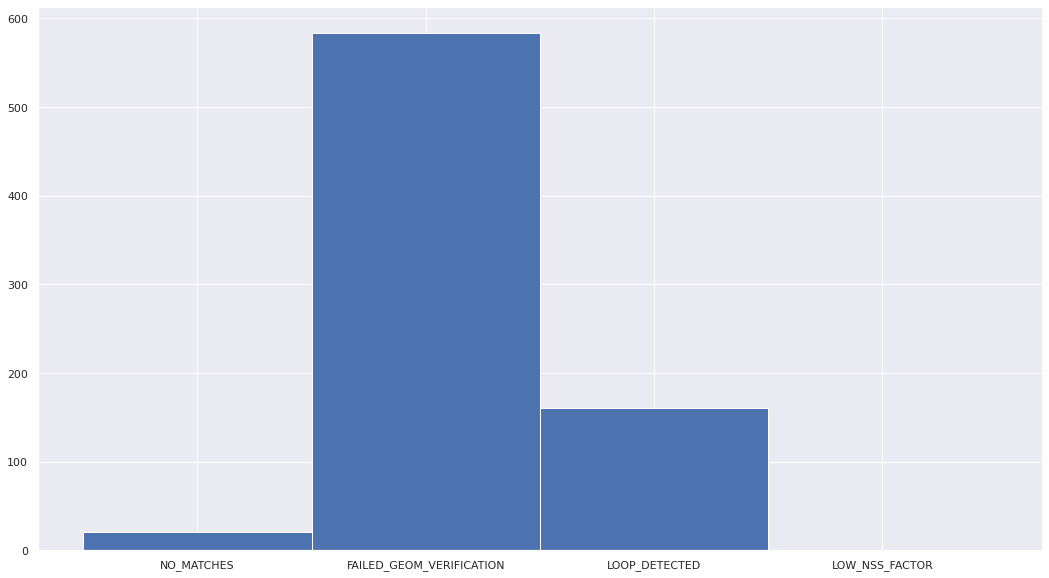

In [5]:
output_lcd_status_filename = os.path.join(os.path.expandvars(vio_output_dir), "output_lcd_status.csv")
lcd_debuginfo_df = pd.read_csv(output_lcd_status_filename, sep=',', index_col=0)

status_freq_map = {}

for status in lcd_debuginfo_df.lcd_status:
    if status not in status_freq_map:
        status_freq_map[status] = 1
    else:
        status_freq_map[status] += 1


print("Full Size of PGO:                       ", lcd_debuginfo_df.pgo_size.tolist()[-1])

# Print the overall number of loop closures detected over all time.
if "LOOP_DETECTED" in status_freq_map:
    print("Loop Closures Detected:                 ", status_freq_map["LOOP_DETECTED"])
else:
    print("Loop Closures Detected:                 0")

print("Loop Closures Registered by PGO by End: ", lcd_debuginfo_df.pgo_lc_count.tolist()[-1])
print("Loop Closures Accepted by PGO at End:   ", lcd_debuginfo_df.pgo_lc_inliers.tolist()[-1])

# Plot failure modes as a histogram.
fig = plt.figure(figsize=(18,10))
plt.bar(status_freq_map.keys(), status_freq_map.values(), width=1.0)

plt.xticks(status_freq_map.keys(), list(status_freq_map.keys()))
plt.ylabel('Status Frequency')
plt.title('LoopClosureDetector Status Histogram')

plt.show()

### LCD RANSAC Performance Charts

Plot the performance of the geometric-verification and pose-recovery steps. These are handled by Nister (5pt) RANSAC and Arun (3pt) RANSAC respectively.

inlier percentages and iterations are plotted for both methods.


RANSAC Statistic Summary for Loop Closures ONLY:

Average number of mono ransac inliers  : 6.391425970054293e+16
Average size of mono ransac input      : 2.2180705033531277e+17
Average number of stereo ransac inliers: 2.334102057409668e+18
Average size of stereo ransac input    : 8.319099728686556e+18
Maximum mono ransac iterations         : 1936287860
Maximum stereo ransac iterations       : 1752459639


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 11

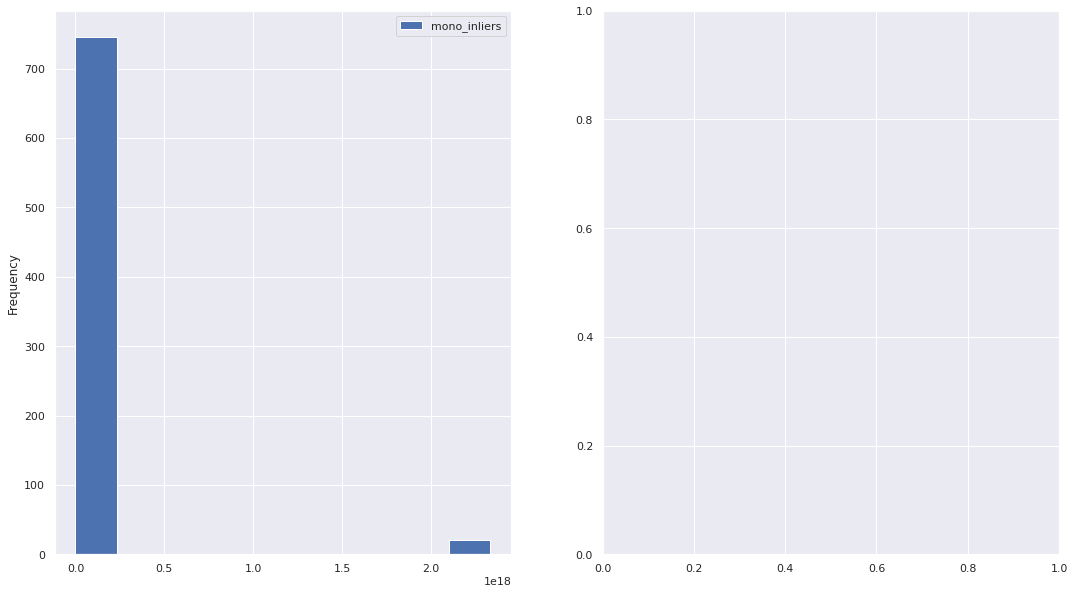

In [7]:
lcd_debuginfo_small_df = downsize_lc_df(lcd_debuginfo_df)

#Helper functions for processing data summary.
def get_mean(attrib):
    ls = lcd_debuginfo_small_df[attrib].tolist()
    return float(sum(ls)) / len(ls)

def get_min(attrib):
    return min(lcd_debuginfo_small_df[attrib])

def get_max(attrib):
    return max(lcd_debuginfo_small_df[attrib])

# Construct and visualize summary. TODO(marcus): use a LaTeX table.
summary_stats = [
    ("Average number of mono ransac inliers", get_mean("mono_inliers")),
    ("Average size of mono ransac input", get_mean("mono_input_size")),
    ("Average number of stereo ransac inliers", get_mean("stereo_inliers")),
    ("Average size of stereo ransac input", get_mean("stereo_input_size")),
    ("Maximum mono ransac iterations", get_max("mono_iters")),
    ("Maximum stereo ransac iterations", get_max("stereo_iters")),
]

attrib_len = [len(attrib[0]) for attrib in summary_stats]
max_attrib_len = max(attrib_len)

print("\nRANSAC Statistic Summary for Loop Closures ONLY:\n")
for entry in summary_stats:
    attrib = entry[0]
    value = entry[1]
    spacing = max_attrib_len - len(attrib)
    print(attrib + " "*spacing + ": " + str(value))
    
    
# Plot ransac inlier and iteration statistics.
fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(18,10), squeeze=False)

lcd_debuginfo_small_df.plot(kind="hist", y="mono_inliers", ax=axes1[0,0])
lcd_debuginfo_small_df.plot(kind="hist", y="stereo_inliers", ax=axes1[0,0])
lcd_debuginfo_small_df.plot(kind="hist", y="mono_iters", ax=axes1[0,1])
lcd_debuginfo_small_df.plot(kind="hist", y="stereo_iters", ax=axes1[0,1])

plt.show()

### LCD Relative Pose Error Plotting

Calculate error statistics for all individual loop closures and plot their error as compared to ground truth. These plots give insight into how reliable the pose determination between two frames is for each loop closure. This pose determination is done via a combination of 5-pt and 3-pt RANSAC matching of the stereo images from the camera.

In [ ]:
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)
rename_euroc_gt_df(gt_df)

output_loop_closures_filename = os.path.join(os.path.expandvars(vio_output_dir), "traj_pgo.csv")
output_loop_closures_df = pd.read_csv(output_loop_closures_filename, sep=',', index_col=0)

In [8]:
small_lc_df = downsize_lc_df(output_loop_closures_df)
rename_lcd_result_df(small_lc_df)
gt_rel_df = convert_abs_traj_to_rel_traj_lcd(gt_df, small_lc_df, to_scale=True)

NameError: name 'output_loop_closures_df' is not defined

In [9]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_rel_df)

# Use the mono ransac file as estimated trajectory.
traj_est = pandas_bridge.df_to_trajectory(small_lc_df)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)

print("traj_ref: ", traj_ref)
print("traj_est: ", traj_est)

NameError: name 'gt_rel_df' is not defined

In [10]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe((traj_ref, traj_est), metrics.PoseRelation.rotation_angle_deg)
rpe_tran = get_rpe((traj_ref, traj_est), metrics.PoseRelation.translation_part)

# Print rotation RPE statistics:
rot_summary_stats = [
    ("mean", rpe_rot.get_statistic(metrics.StatisticsType.mean)),
    ("median", rpe_rot.get_all_statistics()["median"]),
    ("rmse", rpe_rot.get_statistic(metrics.StatisticsType.rmse)),
    ("std", rpe_rot.get_statistic(metrics.StatisticsType.std)),
    ("min", rpe_rot.get_statistic(metrics.StatisticsType.min)),
    ("max", rpe_rot.get_statistic(metrics.StatisticsType.max))
]

attrib_len = [len(attrib[0]) for attrib in rot_summary_stats]
max_attrib_len = max(attrib_len)

print("\nRotation RPE Statistics Summary:\n")
for entry in rot_summary_stats:
    attrib = entry[0]
    value = entry[1]
    spacing = max_attrib_len - len(attrib)
    print(attrib + " "*spacing + ": " + str(value))
    

# Print translation RPE statistics:
tram_summary_stats = [
    ("mean", rpe_tran.get_statistic(metrics.StatisticsType.mean)),
    ("median", rpe_tran.get_all_statistics()["median"]),
    ("rmse", rpe_tran.get_statistic(metrics.StatisticsType.rmse)),
    ("std", rpe_tran.get_statistic(metrics.StatisticsType.std)),
    ("min", rpe_tran.get_statistic(metrics.StatisticsType.min)),
    ("max", rpe_tran.get_statistic(metrics.StatisticsType.max))
]

attrib_len = [len(attrib[0]) for attrib in tram_summary_stats]
max_attrib_len = max(attrib_len)

print("\nTranslation RPE Statistics Summary:\n")
for entry in tram_summary_stats:
    attrib = entry[0]
    value = entry[1]
    spacing = max_attrib_len - len(attrib)
    print(attrib + " "*spacing + ": " + str(value))

NameError: name 'traj_ref' is not defined

## LoopClosureDetector PGO-Optimized Trajectory Plotting

Plot the APE, RPE, and trajectory of the Pose-graph-optimized trajectory, including loop closures on top of regular odometry updates.

The results are visualized against both ground truth and the odometry-estimate alone to show the performance gain from loop closure detection.

In [11]:
# Load ground truth and estimated data as csv DataFrames.
gt_df = pd.read_csv(gt_data_file, sep=',', index_col=0)

output_poses_filename = os.path.join(os.path.expandvars(vio_output_dir), "traj_vio.csv")
output_poses_df = pd.read_csv(output_poses_filename, sep=',', index_col=0)

output_pgo_poses_filename = os.path.join(os.path.expandvars(vio_output_dir), "traj_pgo.csv")
output_pgo_poses_df = pd.read_csv(output_pgo_poses_filename, sep=',', index_col=0)

In [12]:
gt_df = gt_df[~gt_df.index.duplicated()]

rename_euroc_gt_df(gt_df)

In [20]:
# Convert the gt relative-pose DataFrame to a trajectory object.
traj_ref = pandas_bridge.df_to_trajectory(gt_df)

discard_n_start_poses = 80
discard_n_end_poses = 0

# Compare against the VIO without PGO.
traj_ref_cp = copy.deepcopy(traj_ref)
traj_vio = pandas_bridge.df_to_trajectory(output_poses_df)
traj_ref_cp, traj_vio = sync.associate_trajectories(traj_ref_cp, traj_vio)
traj_vio = trajectory.align_trajectory(traj_vio, traj_ref_cp, correct_scale=False,
                                       discard_n_start_poses = int(discard_n_start_poses),
                                       discard_n_end_poses = int(discard_n_end_poses))

# Use the PGO output as estimated trajectory.
traj_est = pandas_bridge.df_to_trajectory(output_pgo_poses_df)

# Associate the data.
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)
traj_est = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=False,
                                       discard_n_start_poses = int(discard_n_start_poses),
                                       discard_n_end_poses = int(discard_n_end_poses))

print("traj_ref: ", traj_ref)
print("traj_vio: ", traj_vio)
print("traj_est: ", traj_est)

traj_ref:  766 poses, 107.332m path length, 190.650s duration
traj_vio:  767 poses, 107.327m path length, 190.900s duration
traj_est:  766 poses, 107.567m path length, 190.650s duration


## Absolute-Pose-Error Plotting

Plot absolute-pose-error along the entire trajectory. APE gives a good sense of overall VIO performance across the entire trajectory.

/home/yunchang/python3_virtual/lib/python3.6/site-packages/evo/tools/plot.py:580: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  label=stat_name+" (+/- {0:.5f})".format(std))


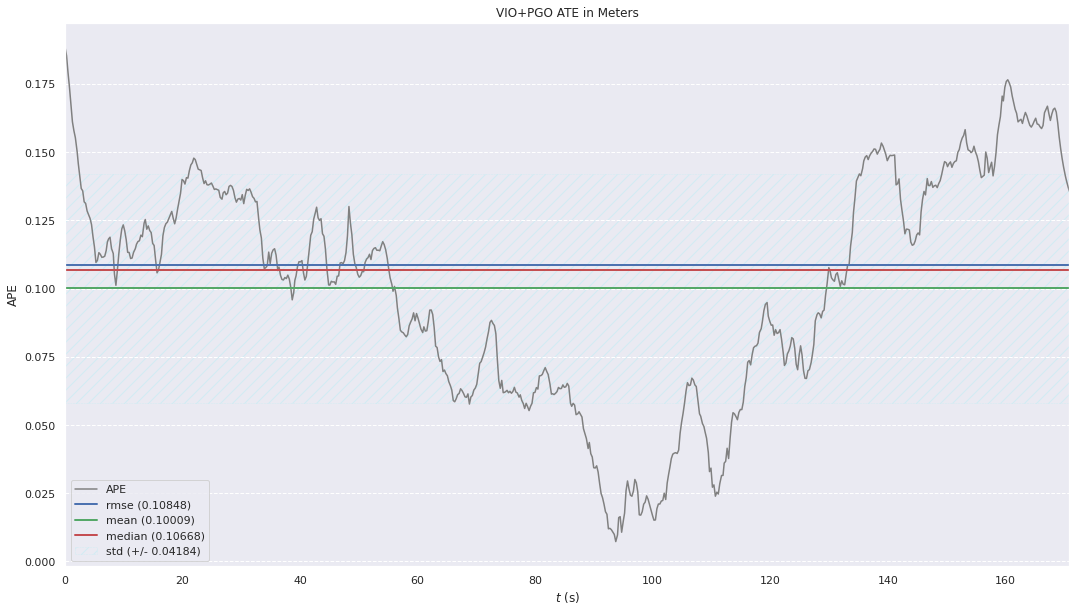

In [21]:
# Plot APE of trajectory rotation and translation parts.
num_of_poses = traj_est.num_poses
traj_est.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))
traj_ref.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))
traj_vio.reduce_to_ids(range(int(discard_n_start_poses), int(num_of_poses - discard_n_end_poses), 1))

seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps]

ape_tran = get_ape((traj_ref, traj_est), metrics.PoseRelation.translation_part)
plot_ape(seconds_from_start, ape_tran, title="VIO+PGO ATE in Meters")

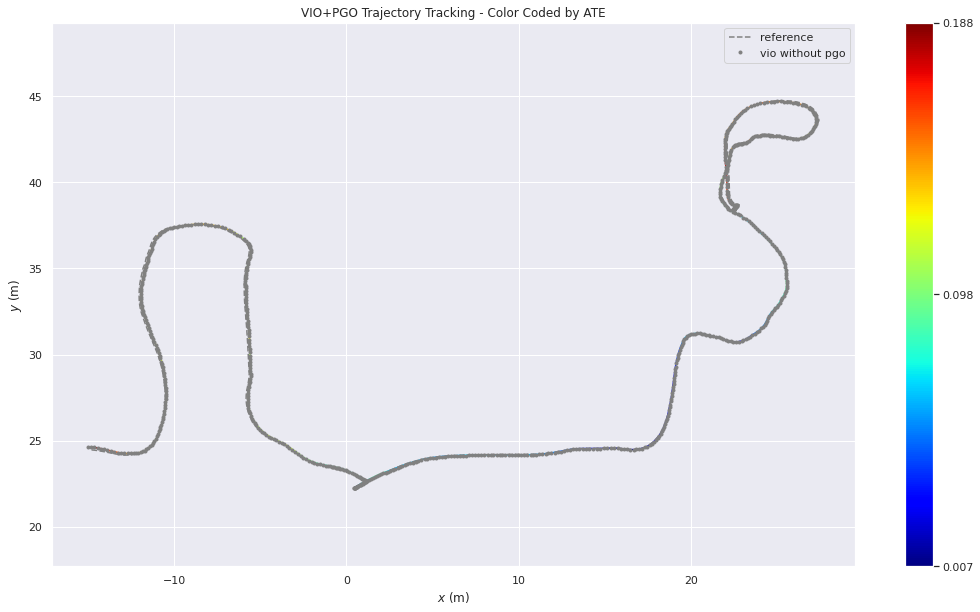

In [25]:
# Plot the ground truth and estimated trajectories against each other with APE overlaid.

plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(18,10))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref, '--', "gray", "reference")
plot.traj(ax, plot_mode, traj_vio, '.', "gray", "vio without pgo")
plot.traj_colormap(ax, traj_est, ape_tran.error, plot_mode,
                   min_map=ape_tran.get_all_statistics()["min"],
                   max_map=ape_tran.get_all_statistics()["max"],
                   title="VIO+PGO Trajectory Tracking - Color Coded by ATE")
ax.legend()
plt.show()

## Relative-Pose-Error Plotting

Plot relative-pose-error along the entire trajectory. RPE gives a good sense of overall VIO performance from one frame to the next.

In [16]:
# Get RPE for entire relative trajectory.
rpe_rot = get_rpe((traj_ref, traj_est), metrics.PoseRelation.rotation_angle_deg)
rpe_tran = get_rpe((traj_ref, traj_est), metrics.PoseRelation.translation_part)

/home/yunchang/python3_virtual/lib/python3.6/site-packages/evo/tools/plot.py:580: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  label=stat_name+" (+/- {0:.5f})".format(std))


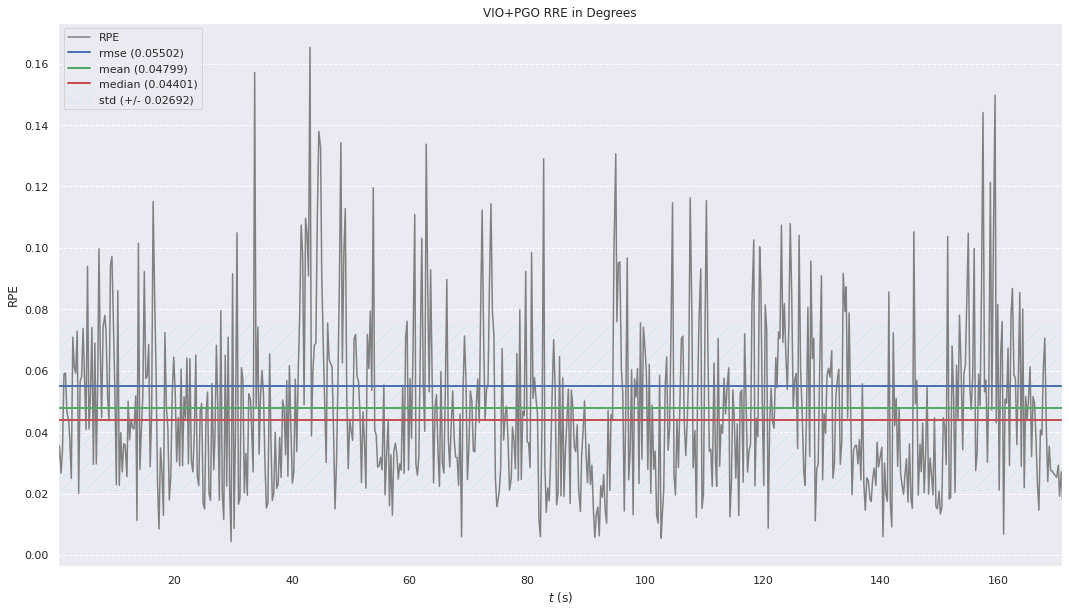

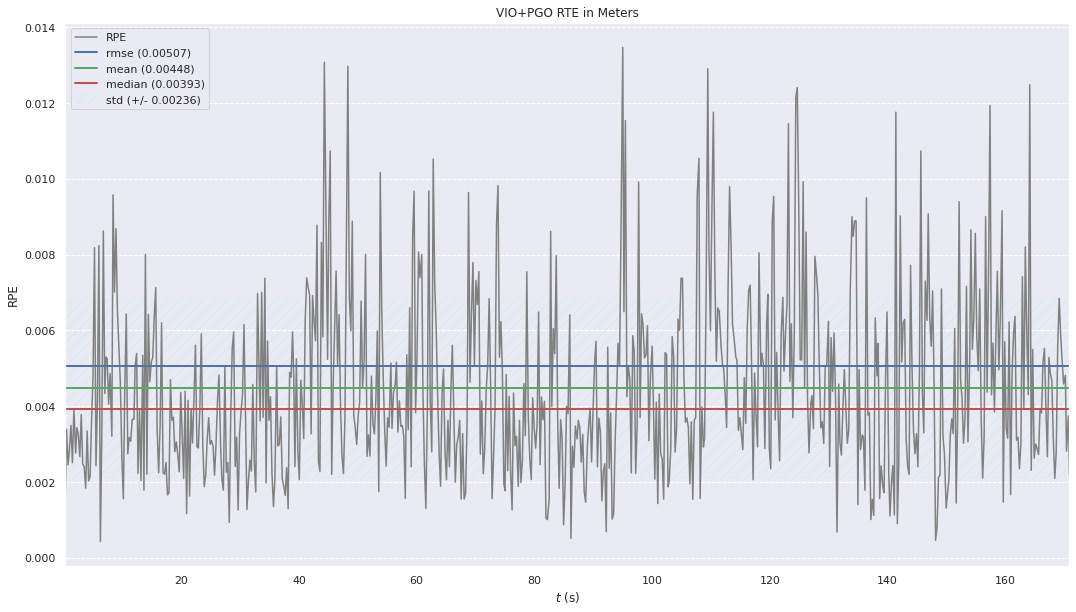

In [17]:
# Plot RPE of trajectory rotation and translation parts.
seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]

plot_rpe(seconds_from_start, rpe_rot, title="VIO+PGO RRE in Degrees")
plot_rpe(seconds_from_start, rpe_tran, title="VIO+PGO RTE in Meters")

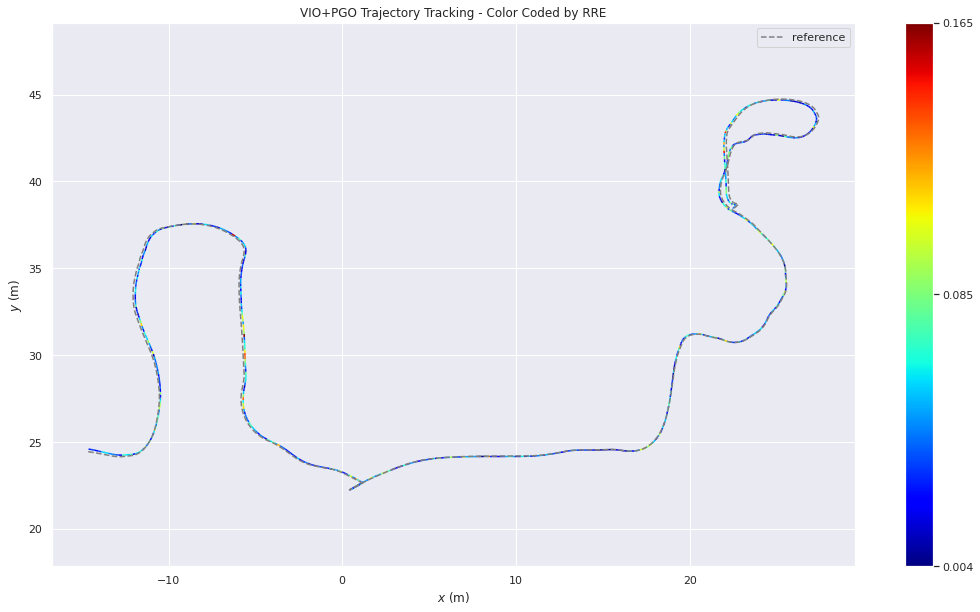

In [18]:
# important: restrict data to delta ids for plot.
traj_ref_plot = copy.deepcopy(traj_ref)
traj_est_plot = copy.deepcopy(traj_est)
traj_ref_plot.reduce_to_ids(rpe_rot.delta_ids)
traj_est_plot.reduce_to_ids(rpe_rot.delta_ids)

# Plot the ground truth and estimated trajectories against each other with RPE overlaid.

plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(18,10))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, traj_ref_plot, '--', "gray", "reference")
plot.traj_colormap(ax, traj_est_plot, rpe_rot.error, plot_mode,
                   min_map=rpe_rot.get_all_statistics()["min"],
                   max_map=rpe_rot.get_all_statistics()["max"],
                   title="VIO+PGO Trajectory Tracking - Color Coded by RRE")
ax.legend()
plt.show()

In [19]:
traj_vio = pandas_bridge.df_to_trajectory(output_poses_df)
traj_ref, traj_vio = sync.associate_trajectories(traj_ref, traj_est)
traj_vio = trajectory.align_trajectory(traj_vio, traj_ref, correct_scale=False)

# Plot the trajectories for quick error visualization.

fig = plt.figure(figsize=(18,10))
traj_by_label = {
    "VIO only": traj_vio,
    "VIO + PGO": traj_est,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz, title="PIM Trajectory Tracking in 3D")
plt.show()

NotImplementedError: It is not currently possible to manually set the aspect on 3D axes

<Figure size 1296x720 with 0 Axes>